In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os
import numpy
from scipy import special
import healpy
import fitsio
import gaia_tools.load, gaia_tools.select
from mwdust import Zero
from galpy.util import bovy_plot, bovy_coords
%pylab inline
from matplotlib.colors import LogNorm
import seaborn as sns
from matplotlib import cm
save_figures= False
numpy.random.seed(1)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# The density of F stars in *TGAS*

First load the *TGAS* data and select F stars:

In [3]:
tgas= gaia_tools.load.tgas()
twomass= gaia_tools.load.twomass()
jk= twomass['j_mag']-twomass['k_mag']
# Select F stars
findx= (jk > 0.12)*(jk < 0.32)
tgas= tgas[findx]
twomass= twomass[findx]
jk= jk[findx]
mj= twomass['j_mag']+5.*numpy.log10(tgas['parallax'])-10.
print("%i TGAS F stars" % (len(tgas)))

666582 TGAS F stars


In [4]:
print("Median color, abs. mag.:",numpy.median(jk[tgas['parallax']/tgas['parallax_error'] > 10.]),
      numpy.median(mj[tgas['parallax']/tgas['parallax_error'] > 10.]))

('Median color, abs. mag.:', 0.27099991, 2.5105843935896814)


Setup the selection and effective-selection function:

In [5]:
tsf= gaia_tools.select.tgasSelect()
dmap_zero= Zero()
tesf= gaia_tools.select.tgasEffectiveSelect(tsf,dmap3d=dmap_zero,MJ=2.5,JK=0.27) 
def bin_func(X,Y,Z,xymin=0.,xymax=0.25,zmin=0.05,zmax=0.15):
    xy= numpy.sqrt(X**2.+Y**2.)
    out= numpy.zeros_like(X)
    out[(xy >= xymin)*(xy < xymax)*(Z >= zmin)*(Z < zmax)]= 1.
    return out

Compute the effective volume:

In [6]:
dz= 0.05
zs= numpy.arange(-0.3,0.35,dz)
effvol= numpy.array([tesf.volume(lambda x,y,z: bin_func(x,y,z,xymax=0.25,zmin=tz-dz/2.,zmax=tz+dz/2.),
                                 xyz=True) for tz in zs])

Compute the data number counts:

In [7]:
dataXYZ= bovy_coords.lbd_to_XYZ(tgas['l'],tgas['b'],1./tgas['parallax'],degree=True)
xyindx= numpy.sqrt(dataXYZ[:,0]**2.+dataXYZ[:,1]**2.) < 0.25
sindx= tsf.determine_statistical(tgas,twomass['j_mag'],twomass['k_mag'])
data_counts= numpy.zeros_like(zs)
for ii,z in enumerate(zs):
    data_counts[ii]= numpy.sum(sindx*xyindx*(dataXYZ[:,2] >= z-dz/2.)*(dataXYZ[:,2] < z+dz/2.))

and the vertical density profile is:

<Container object of 3 artists>

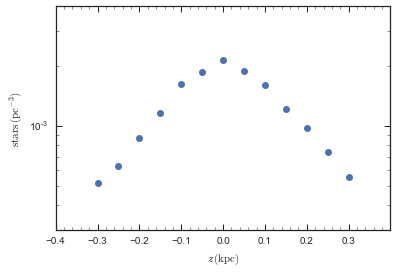

In [8]:
bovy_plot.bovy_plot(zs,data_counts/effvol/10.**9.,'o',
                    xrange=[numpy.amin(zs)-0.1,numpy.amax(zs)+0.1],
                    yrange=[0.0003,0.004],semilogy=True,
                    xlabel=r'$z\,(\mathrm{kpc})$',
                    ylabel=r'$\mathrm{stars}\,(\mathrm{pc}^{-3})$')
pyplot.errorbar(zs,data_counts/effvol/10.**9.,yerr=numpy.sqrt(data_counts)/effvol/10.**9.,marker='None',ls='None')

For comparison, the following is the density law that we would find by simply assuming a constant effective volume (here the median of that used above):

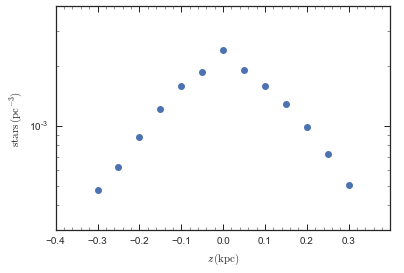

In [9]:
bovy_plot.bovy_plot(zs,data_counts/numpy.median(effvol)/10.**9.,'o',
                    xrange=[numpy.amin(zs)-0.1,numpy.amax(zs)+0.1],
                    yrange=[0.0003,0.004],semilogy=True,
                    xlabel=r'$z\,(\mathrm{kpc})$',
                    ylabel=r'$\mathrm{stars}\,(\mathrm{pc}^{-3})$')

The density data points are:

In [10]:
print("Z center:",zs)
print("Number density (1/pc^3):",data_counts/effvol/10.**9.)

('Z center:', array([ -3.00000000e-01,  -2.50000000e-01,  -2.00000000e-01,
        -1.50000000e-01,  -1.00000000e-01,  -5.00000000e-02,
        -5.55111512e-17,   5.00000000e-02,   1.00000000e-01,
         1.50000000e-01,   2.00000000e-01,   2.50000000e-01,
         3.00000000e-01]))
('Number density (1/pc^3):', array([ 0.00051427,  0.00062659,  0.00086333,  0.00115386,  0.00162137,
        0.00186571,  0.00213472,  0.00188518,  0.00159593,  0.00121838,
        0.00097624,  0.00073776,  0.00054877]))
